<a href="https://colab.research.google.com/github/ichi-269/ucs_vs_cs_project/blob/main/%E3%82%BB%E3%83%AB%E3%82%92%E5%A4%89%E5%8B%95%E3%81%95%E3%81%9B%E3%81%9F%E9%9A%9B%E3%81%AE%E6%8C%99%E5%8B%95%E3%81%AE%E6%AF%94%E8%BC%83.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import random
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools

## サンプリング，モデルの関数

In [2]:
def CS(conts, threshold, is_gene, loops):
    rng = np.random.default_rng()  # 乱数ジェネレーター
    power = np.zeros((loops, 2))

    # ループを実行して条件を満たす乱数を生成
    for i in range(loops):
      power0 = rng.uniform(0 + 1e-10, 1)
      power1 = rng.uniform(0 + 1e-10, threshold)
      # power1 = threshold
      power[i] = [power0,power1]

    a, b, c, d = conts

    # power[:, 0] 原因と結果のw
    # power[:, 1] 背景と結果のw

    if is_gene:
      probs1 = [
          (1 - (1 - power[:, 0]) * (1 - power[:, 1])),# P(E=1|C=1)
          (1 - power[:, 0]) * (1 - power[:, 1]),# P(E=0|C=1)
          power[:, 1],# P(E=1|C=0)
          (1 - power[:, 1]),# P(E=0|C=0)
      ]
    else:
      probs1 = [
          power[:, 1] - (power[:, 0] * power[:, 1]),# P(E=1|C=1)
          1 - (power[:, 1] - (power[:, 0] * power[:, 1])),# P(E=0|C=1)
          power[:, 1],# P(E=1|C=0)
          1 - power[:, 1],# P(E=0|C=0)
      ]

    probs0 = [
        power[:, 1],# P(E=1|C=1)
        (1 - power[:, 1]),# P(E=0|C=1)
        power[:, 1],# P(E=1|C=0)
        (1 - power[:, 1]),# P(E=0|C=0)
    ]

    loglike1 = np.sum((np.ones((loops, 1)) * np.array(conts)) * np.log(probs1).T, axis=1)
    like1 = sum(np.exp(loglike1)) * (1/loops)

    loglike0 = np.sum((np.ones((loops, 1)) * np.array(conts)) * np.log(probs0).T, axis=1)
    like0 = sum(np.exp(loglike0)) * (1/loops)

    logscore = np.log(like1/like0)
    return logscore

In [3]:
def UCS(conts, threshold, is_gene, loops):
    rng = np.random.default_rng()  # 乱数ジェネレーター
    power = np.zeros((loops, 3))

    # ループを実行して条件を満たす乱数を生成
    for i in range(loops):
      power0 = rng.uniform(0 + 1e-10, 1)
      power1 = rng.uniform(0 + 1e-10, threshold)
      power2 = rng.uniform(0 + 1e-10, threshold)
      power[i] = [power0,power1,power2]
    a, b, c, d = conts
    # power[:, 0] 原因と結果のw
    # power[:, 1] 背景と原因のw
    # power[:, 2] 背景と結果のw
    if is_gene:
      # z = /(np.sqrt(power[:, 1] * power[:, 2] * (1 - (1 - power[:, 0]) * (1 - power[:, 1])) * (1 - (1 - power[:, 0]) * (1 - power[:, 2]))) + np.sqrt(power[:, 1] * (1 - power[:, 2]) * (power[:, 1] * ((1 - power[:, 0]) * (1 - power[:, 2])))) + np.sqrt((1 - power[:, 1]) * power[:, 2] * (power[:, 2] * ((1 - power[:, 0]) * (1 - power[:, 1])))) + (1 - power[:, 1]) * (1 - power[:, 2]))
      probs1 = [
          np.sqrt(power[:, 1] * power[:, 2] * (1 - (1 - power[:, 0]) * (1 - power[:, 1])) * (1 - (1 - power[:, 0]) * (1 - power[:, 2])))/(np.sqrt(power[:, 1] * power[:, 2] * (1 - (1 - power[:, 0]) * (1 - power[:, 1])) * (1 - (1 - power[:, 0]) * (1 - power[:, 2]))) + np.sqrt(power[:, 1] * (1 - power[:, 2]) * (power[:, 1] * ((1 - power[:, 0]) * (1 - power[:, 2])))) + np.sqrt((1 - power[:, 1]) * power[:, 2] * (power[:, 2] * ((1 - power[:, 0]) * (1 - power[:, 1])))) + (1 - power[:, 1]) * (1 - power[:, 2])),
          np.sqrt(power[:, 1] * (1 - power[:, 2]) * (power[:, 1] * ((1 - power[:, 0]) * (1 - power[:, 2]))))/(np.sqrt(power[:, 1] * power[:, 2] * (1 - (1 - power[:, 0]) * (1 - power[:, 1])) * (1 - (1 - power[:, 0]) * (1 - power[:, 2]))) + np.sqrt(power[:, 1] * (1 - power[:, 2]) * (power[:, 1] * ((1 - power[:, 0]) * (1 - power[:, 2])))) + np.sqrt((1 - power[:, 1]) * power[:, 2] * (power[:, 2] * ((1 - power[:, 0]) * (1 - power[:, 1])))) + (1 - power[:, 1]) * (1 - power[:, 2])),
          np.sqrt((1 - power[:, 1]) * power[:, 2] * (power[:, 2] * ((1 - power[:, 0]) * (1 - power[:, 1]))))/(np.sqrt(power[:, 1] * power[:, 2] * (1 - (1 - power[:, 0]) * (1 - power[:, 1])) * (1 - (1 - power[:, 0]) * (1 - power[:, 2]))) + np.sqrt(power[:, 1] * (1 - power[:, 2]) * (power[:, 1] * ((1 - power[:, 0]) * (1 - power[:, 2])))) + np.sqrt((1 - power[:, 1]) * power[:, 2] * (power[:, 2] * ((1 - power[:, 0]) * (1 - power[:, 1])))) + (1 - power[:, 1]) * (1 - power[:, 2])),
          (1 - power[:, 1]) * (1 - power[:, 2])/(np.sqrt(power[:, 1] * power[:, 2] * (1 - (1 - power[:, 0]) * (1 - power[:, 1])) * (1 - (1 - power[:, 0]) * (1 - power[:, 2]))) + np.sqrt(power[:, 1] * (1 - power[:, 2]) * (power[:, 1] * ((1 - power[:, 0]) * (1 - power[:, 2])))) + np.sqrt((1 - power[:, 1]) * power[:, 2] * (power[:, 2] * ((1 - power[:, 0]) * (1 - power[:, 1])))) + (1 - power[:, 1]) * (1 - power[:, 2])),
      ]
    else:
      # z = / (np.sqrt((power[:, 1] * power[:, 2]) * ((power[:, 1] * (1 - power[:, 0])) * (power[:, 2] * (1 - power[:, 0])))) + np.sqrt((power[:, 1] * (1 - power[:, 2])) * (power[:, 1] * (1 - (power[:, 2] * (1 - power[:, 0]))))) + np.sqrt(((1 - power[:, 1]) * power[:, 2]) * ((1 - (power[:, 1] * (1 - power[:, 0]))) * power[:, 2])) + (1 - power[:, 1]) * (1 - power[:, 2]))
      probs1 = [
          np.sqrt((power[:, 1] * power[:, 2]) * ((power[:, 1] * (1 - power[:, 0])) * (power[:, 2] * (1 - power[:, 0]))))  / (np.sqrt((power[:, 1] * power[:, 2]) * ((power[:, 1] * (1 - power[:, 0])) * (power[:, 2] * (1 - power[:, 0])))) + np.sqrt((power[:, 1] * (1 - power[:, 2])) * (power[:, 1] * (1 - (power[:, 2] * (1 - power[:, 0]))))) + np.sqrt(((1 - power[:, 1]) * power[:, 2]) * ((1 - (power[:, 1] * (1 - power[:, 0]))) * power[:, 2])) + (1 - power[:, 1]) * (1 - power[:, 2])),
          np.sqrt((power[:, 1] * (1 - power[:, 2])) * (power[:, 1] * (1 - (power[:, 2] * (1 - power[:, 0])))))  / (np.sqrt((power[:, 1] * power[:, 2]) * ((power[:, 1] * (1 - power[:, 0])) * (power[:, 2] * (1 - power[:, 0])))) + np.sqrt((power[:, 1] * (1 - power[:, 2])) * (power[:, 1] * (1 - (power[:, 2] * (1 - power[:, 0]))))) + np.sqrt(((1 - power[:, 1]) * power[:, 2]) * ((1 - (power[:, 1] * (1 - power[:, 0]))) * power[:, 2])) + (1 - power[:, 1]) * (1 - power[:, 2])),
          np.sqrt(((1 - power[:, 1]) * power[:, 2]) * ((1 - (power[:, 1] * (1 - power[:, 0]))) * power[:, 2]))  / (np.sqrt((power[:, 1] * power[:, 2]) * ((power[:, 1] * (1 - power[:, 0])) * (power[:, 2] * (1 - power[:, 0])))) + np.sqrt((power[:, 1] * (1 - power[:, 2])) * (power[:, 1] * (1 - (power[:, 2] * (1 - power[:, 0]))))) + np.sqrt(((1 - power[:, 1]) * power[:, 2]) * ((1 - (power[:, 1] * (1 - power[:, 0]))) * power[:, 2])) + (1 - power[:, 1]) * (1 - power[:, 2])),
          (1 - power[:, 1]) * (1 - power[:, 2])  / (np.sqrt((power[:, 1] * power[:, 2]) * ((power[:, 1] * (1 - power[:, 0])) * (power[:, 2] * (1 - power[:, 0])))) + np.sqrt((power[:, 1] * (1 - power[:, 2])) * (power[:, 1] * (1 - (power[:, 2] * (1 - power[:, 0]))))) + np.sqrt(((1 - power[:, 1]) * power[:, 2]) * ((1 - (power[:, 1] * (1 - power[:, 0]))) * power[:, 2])) + (1 - power[:, 1]) * (1 - power[:, 2])),
      ]
    probs0 = [
        power[:, 1] * power[:, 2],
        power[:, 1] * (1 - power[:, 2]),
        (1 - power[:, 1]) * power[:, 2],
        (1 - power[:, 1]) * (1 - power[:, 2]),
    ]

    loglike1 = np.sum((np.ones((loops, 1)) * np.array(conts)) * np.log(probs1).T, axis=1)
    like1 = sum(np.exp(loglike1)) * (1/loops)

    loglike0 = np.sum((np.ones((loops, 1)) * np.array(conts)) * np.log(probs0).T, axis=1)
    like0 = sum(np.exp(loglike0)) * (1/loops)

    logscore = np.log(like1/like0)
    return logscore

In [4]:
def sample_from_distribution(a, b, c, d, n_samples):
    # 確率のリスト
    probabilities = [a, b, c, d]

    # 値のリスト
    values = ['A', 'B', 'C', 'D']

    # サンプリングを実行
    samples = np.random.choice(values, size=n_samples, p=probabilities)

    # 各値が得られた回数をカウント
    counts = {value: 0 for value in values}
    for sample in samples:
        counts[sample] += 1

    # カウントを配列に変換
    count_array = [counts[value] for value in values]

    return count_array

## サンプリング

In [5]:
sample_sizes = [7]
thresholds = [i / 10 for i in range(1, 11)]  # 0.0 to 1.0 in 0.1 increments
loop_count = 10000
df = pd.DataFrame()
random.seed(time.time())
for sample_size in sample_sizes:
  for i in range(1000):
    a = random.randint(0, sample_size)
    b = random.randint(0, sample_size)
    c = random.randint(0, sample_size)
    d = random.randint(0, sample_size)

    results = {'sample_size': a + b + c + d, 'a': a, 'b': b, 'c': c, 'd': d}
    for threshold in thresholds:
        results[f'cs_{threshold}'] = CS([a, b, c, d], threshold, True, loop_count)
        results[f'ucs_{threshold}'] = UCS([a, b, c, d], threshold, True, loop_count)

    dice = (2*a) / (2*a + b + c) if (2*a + b + c) != 0 else None
    phi = (a * d - b * c) / math.sqrt((a + b) * (a + c) * (b + d) * (c + d)) \
        if (a + b) * (a + c) * (b + d) * (c + d) != 0 else None
    deltap = (a / (a + b) - c / (c + d)) \
        if (a + b) != 0 and (c + d) != 0 else None
    pe_c = a / (a + b) if (a + b) != 0 else None

    results.update({'dice_value': dice, 'phi_value': phi, 'deltap_value': deltap, 'pe_c_value': pe_c})
    df = pd.concat([df, pd.DataFrame([results])], ignore_index=True)

In [6]:
df

,sample_size,a,b,c,d,cs_0.1,ucs_0.1,cs_0.2,ucs_0.2,cs_0.3,...,cs_0.8,ucs_0.8,cs_0.9,ucs_0.9,cs_1.0,ucs_1.0,dice_value,phi_value,deltap_value,pe_c_value
0,6,0,2,2,2,-1.103861,-1.065610,-1.104631,-1.059205,-1.102546,...,-1.094360,-1.038546,-1.103174,-1.017232,-1.103501,-1.015401,0.000000,-0.500000,-0.500000,0.000000
1,18,3,6,3,6,1.393023,1.972118,-0.015023,0.514078,-0.578981,...,-1.019621,-0.733993,-1.025569,-0.751081,-1.039056,-0.750586,0.400000,0.000000,0.000000,0.333333
2,15,4,4,3,4,3.960788,4.242070,1.710622,2.021542,0.656759,...,-0.536792,-0.352648,-0.548095,-0.374184,-0.525175,-0.318708,0.533333,0.071429,0.071429,0.500000
3,19,3,6,7,3,1.171171,1.078857,-0.231475,-0.350956,-0.860296,...,-1.527026,-1.564755,-1.540945,-1.542126,-1.587920,-1.523211,0.315789,-0.366667,-0.366667,0.333333
4,13,3,3,5,2,2.770078,2.224163,1.069694,0.696012,0.258125,...,-0.877675,-0.932746,-0.909435,-0.948696,-0.907938,-0.979769,0.428571,-0.219578,-0.214286,0.500000
5,25,6,7,7,5,5.077876,5.247386,1.796914,2.020978,0.307934,...,-1.237434,-1.131280,-1.219560,-1.188466,-1.228437,-1.149786,0.461538,-0.121795,-0.121795,0.461538
6,14,5,1,1,7,9.337127,9.248323,6.277771,6.322718,4.700022,...,2.929713,3.146066,2.933745,3.137820,2.926799,3.185278,0.833333,0.708333,0.708333,0.833333
7,10,0,4,5,1,-1.593340,-1.713069,-1.582868,-1.651492,-1.619556,...,-1.611919,-1.682632,-1.609670,-1.616653,-1.597373,-1.653809,0.000000,-0.816497,-0.833333,0.000000
8,6,1,2,3,0,0.255503,0.090100,-0.233740,-0.413528,-0.496373,...,-0.902097,-0.974256,-0.916947,-0.972967,-0.927891,-0.977264,0.285714,-0.707107,-0.666667,0.333333
9,14,2,0,6,6,3.866682,1.526630,2.607838,0.660725,1.912334,...,0.791757,0.390206,0.796785,0.375696,0.786642,0.376177,0.400000,0.353553,0.500000,1.000000


In [7]:
df.corr()

,sample_size,a,b,c,d,cs_0.1,ucs_0.1,cs_0.2,ucs_0.2,cs_0.3,...,cs_0.8,ucs_0.8,cs_0.9,ucs_0.9,cs_1.0,ucs_1.0,dice_value,phi_value,deltap_value,pe_c_value
sample_size,1.000000,0.815585,6.872790e-01,0.561395,6.099904e-01,0.476652,0.511888,0.301924,0.355687,0.169626,...,-0.035249,0.002826,-0.030989,-0.011217,-0.035398,-0.000651,0.471648,0.405515,0.381052,0.325641
a,0.815585,1.000000,3.704309e-01,0.148111,6.751863e-01,0.837780,0.886174,0.697856,0.778524,0.578128,...,0.369905,0.426320,0.372022,0.410416,0.370100,0.421982,0.841496,0.666912,0.629298,0.557858
b,0.687279,0.370431,1.000000e+00,0.456364,-7.185783e-17,-0.171004,-0.012580,-0.369892,-0.182299,-0.498652,...,-0.638335,-0.560615,-0.635526,-0.568116,-0.638259,-0.558847,-0.088956,-0.285308,-0.332638,-0.424896
c,0.561395,0.148111,4.563642e-01,1.000000,-7.162871e-02,-0.143015,-0.227056,-0.249766,-0.360383,-0.325362,...,-0.472298,-0.536757,-0.469452,-0.542269,-0.474336,-0.540533,-0.192738,-0.221213,-0.191058,0.060258
d,0.609990,0.675186,-7.185783e-17,-0.071629,1.000000e+00,0.763798,0.729033,0.740006,0.718671,0.707606,...,0.644637,0.671911,0.648099,0.662900,0.645834,0.668599,0.711872,0.913998,0.905057,0.696273
cs_0.1,0.476652,0.837780,-1.710035e-01,-0.143015,7.637976e-01,1.000000,0.969789,0.975319,0.965515,0.928406,...,0.807947,0.829190,0.809174,0.819123,0.808533,0.825379,0.946043,0.893145,0.874133,0.811965
ucs_0.1,0.511888,0.886174,-1.257976e-02,-0.227056,7.290329e-01,0.969789,1.000000,0.916665,0.980270,0.852381,...,0.726204,0.779435,0.727443,0.769138,0.727155,0.777343,0.942477,0.827228,0.788800,0.662529
cs_0.2,0.301924,0.697856,-3.698916e-01,-0.249766,7.400061e-01,0.975319,0.916665,1.000000,0.954908,0.987457,...,0.915369,0.921051,0.916071,0.914298,0.915681,0.917862,0.909273,0.909953,0.900351,0.846210
ucs_0.2,0.355687,0.778524,-1.822989e-01,-0.360383,7.186713e-01,0.965515,0.980270,0.954908,1.000000,0.919949,...,0.837802,0.883605,0.838550,0.876326,0.838739,0.882325,0.928971,0.854296,0.819971,0.682874
cs_0.3,0.169626,0.578128,-4.986518e-01,-0.325362,7.076058e-01,0.928406,0.852381,0.987457,0.919949,1.000000,...,0.965558,0.961058,0.965840,0.956779,0.965595,0.958344,0.858014,0.899287,0.896474,0.845295


In [8]:
# tmp_df = df['cs_value','cs_unif_value']
tmp_df = df.loc[:,['cs_0.1','cs_0.3','cs_1.0', 'ucs_0.1', 'ucs_0.3', 'ucs_1.0','dice_value','phi_value','deltap_value', 'pe_c_value']]
tmp_df.corr()

,cs_0.1,cs_0.3,cs_1.0,ucs_0.1,ucs_0.3,ucs_1.0,dice_value,phi_value,deltap_value,pe_c_value
cs_0.1,1.000000,0.928406,0.808533,0.969789,0.934633,0.825379,0.946043,0.893145,0.874133,0.811965
cs_0.3,0.928406,1.000000,0.965595,0.852381,0.950873,0.958344,0.858014,0.899287,0.896474,0.845295
cs_1.0,0.808533,0.965595,1.000000,0.727155,0.908475,0.989558,0.733103,0.838897,0.840755,0.759514
ucs_0.1,0.969789,0.852381,0.727155,1.000000,0.934495,0.777343,0.942477,0.827228,0.788800,0.662529
ucs_0.3,0.934633,0.950873,0.908475,0.934495,1.000000,0.944638,0.894627,0.855642,0.826487,0.687568
ucs_1.0,0.825379,0.958344,0.989558,0.777343,0.944638,1.000000,0.765875,0.846309,0.836285,0.705682
dice_value,0.946043,0.858014,0.733103,0.942477,0.894627,0.765875,1.000000,0.856019,0.833578,0.793145
phi_value,0.893145,0.899287,0.838897,0.827228,0.855642,0.846309,0.856019,1.000000,0.995718,0.855084
deltap_value,0.874133,0.896474,0.840755,0.788800,0.826487,0.836285,0.833578,0.995718,1.000000,0.888020
pe_c_value,0.811965,0.845295,0.759514,0.662529,0.687568,0.705682,0.793145,0.855084,0.888020,1.000000


In [9]:
tmp_df.corr(method='spearman')

,cs_0.1,cs_0.3,cs_1.0,ucs_0.1,ucs_0.3,ucs_1.0,dice_value,phi_value,deltap_value,pe_c_value
cs_0.1,1.000000,0.915152,0.648485,0.963636,0.975758,0.624242,0.963433,0.878788,0.878788,0.851998
cs_0.3,0.915152,1.000000,0.854545,0.818182,0.951515,0.806061,0.859772,0.866667,0.866667,0.950780
cs_1.0,0.648485,0.854545,1.000000,0.575758,0.757576,0.951515,0.646353,0.769697,0.769697,0.833476
ucs_0.1,0.963636,0.818182,0.575758,1.000000,0.939394,0.551515,0.981726,0.806061,0.806061,0.747042
ucs_0.3,0.975758,0.951515,0.757576,0.939394,1.000000,0.733333,0.963433,0.878788,0.878788,0.870520
ucs_1.0,0.624242,0.806061,0.951515,0.551515,0.733333,1.000000,0.609767,0.818182,0.818182,0.747042
dice_value,0.963433,0.859772,0.646353,0.981726,0.963433,0.609767,1.000000,0.835381,0.835381,0.807516
phi_value,0.878788,0.866667,0.769697,0.806061,0.878788,0.818182,0.835381,1.000000,1.000000,0.851998
deltap_value,0.878788,0.866667,0.769697,0.806061,0.878788,0.818182,0.835381,1.000000,1.000000,0.851998
pe_c_value,0.851998,0.950780,0.833476,0.747042,0.870520,0.747042,0.807516,0.851998,0.851998,1.000000


##プロット 二つのセル毎の変化

In [ ]:
variables = ['a', 'b', 'c', 'd']

# すべての2変数の組み合わせを取得
combinations = list(itertools.combinations(variables, 2))

Dice 係数

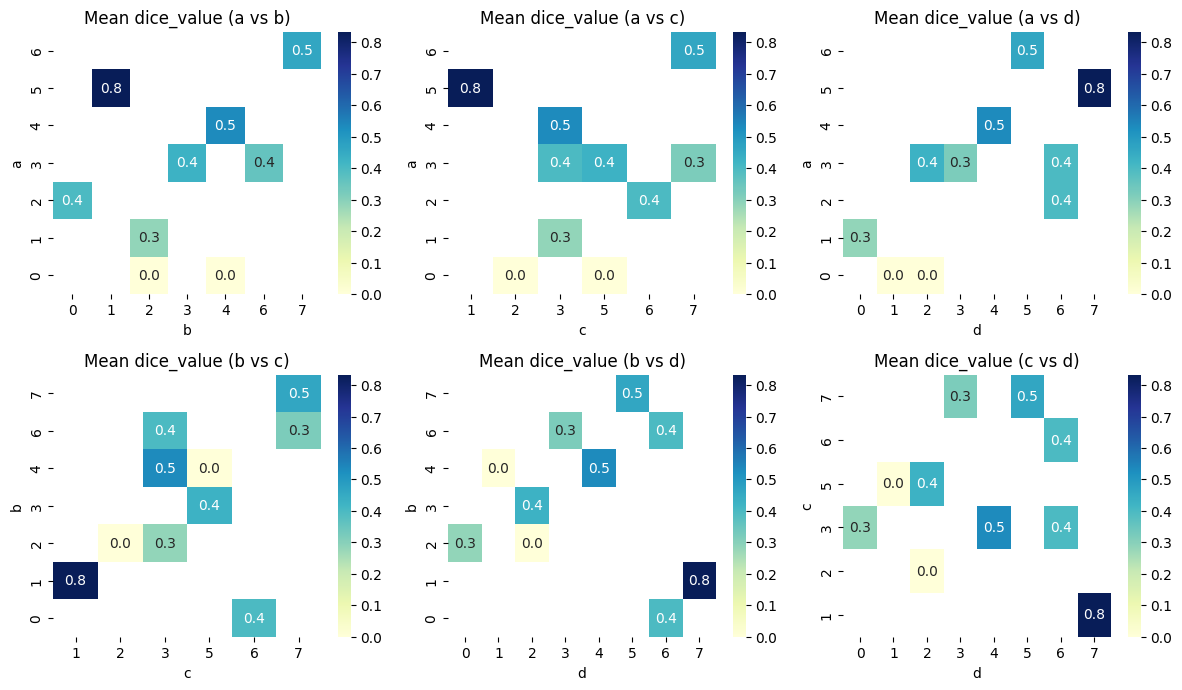

In [12]:
# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='dice_value', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean dice_value ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()


pARIs

UCS 0.1

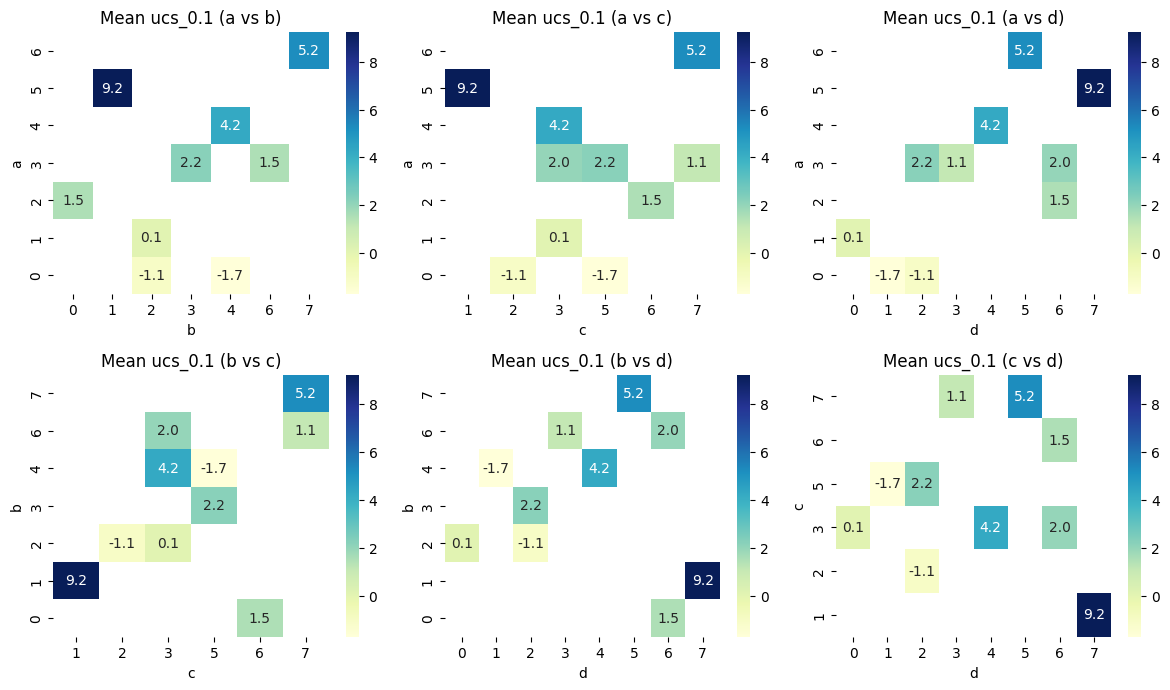

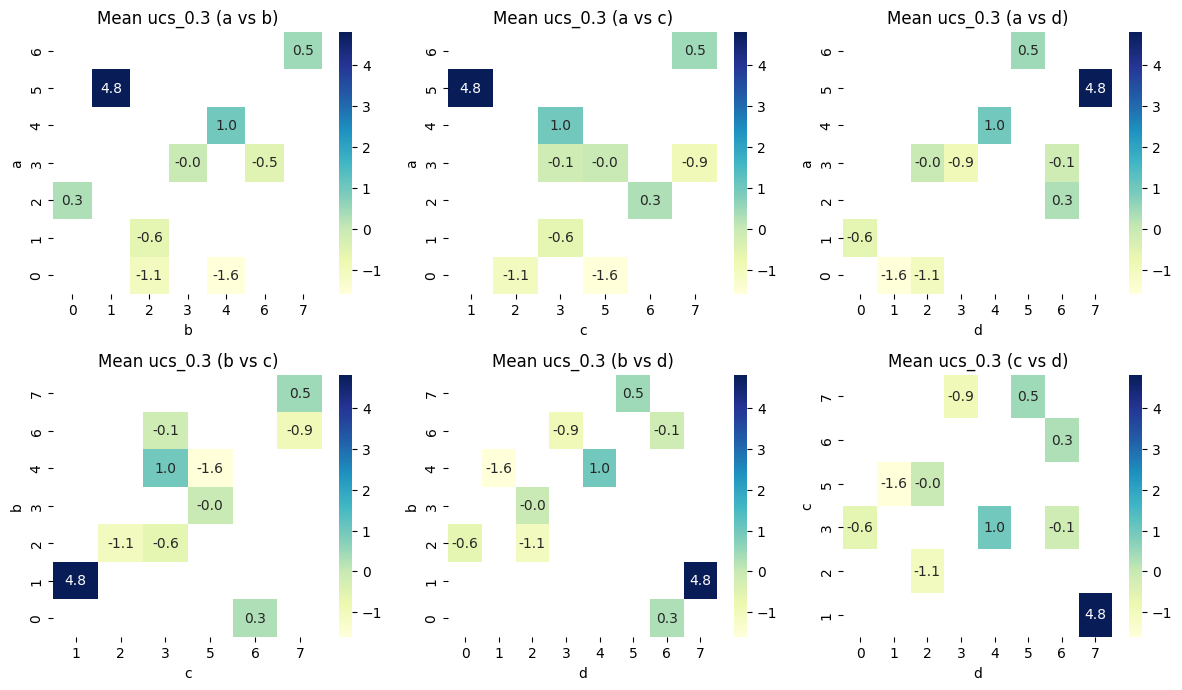

In [15]:
# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='ucs_0.1', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean ucs_0.1 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()

# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='ucs_0.3', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean ucs_0.3 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()

# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='ucs_0.5', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean ucs_0.5 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()

# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='ucs_1.0', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean ucs_1.0 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()

CS

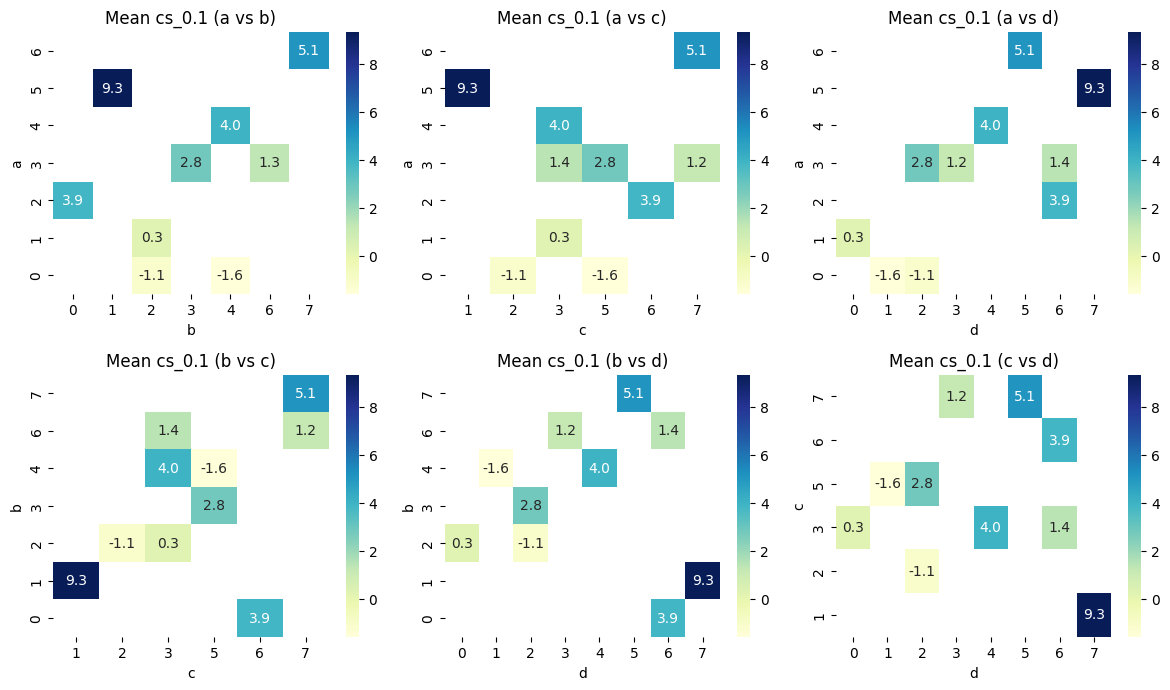

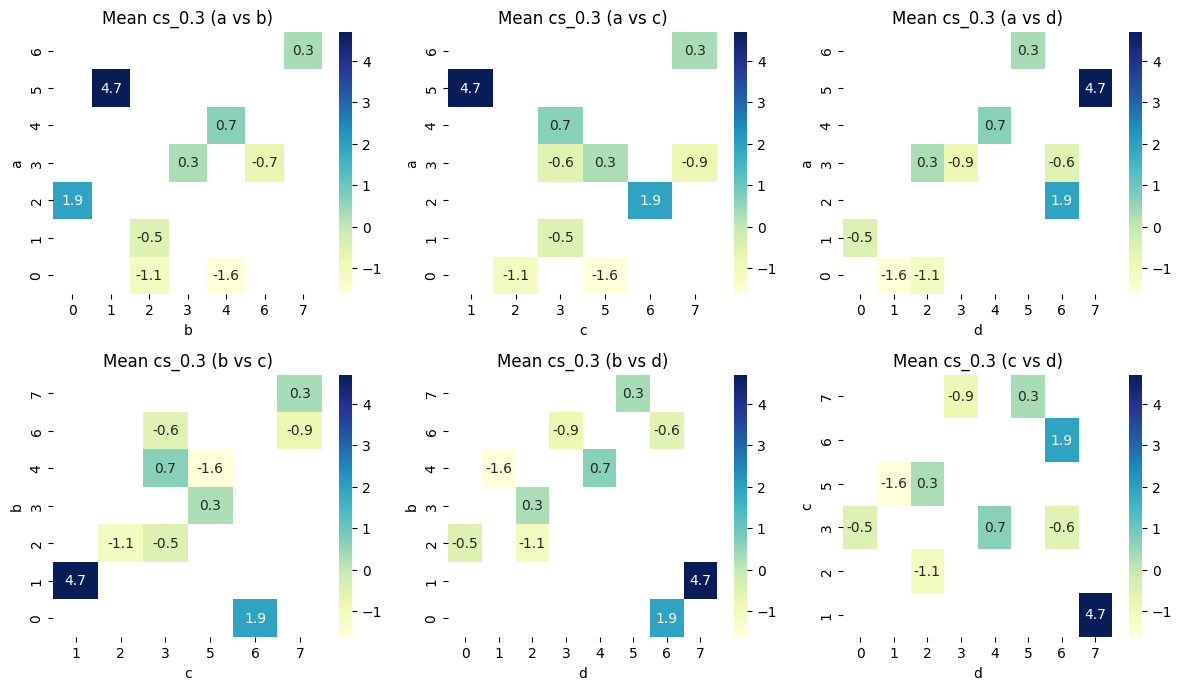

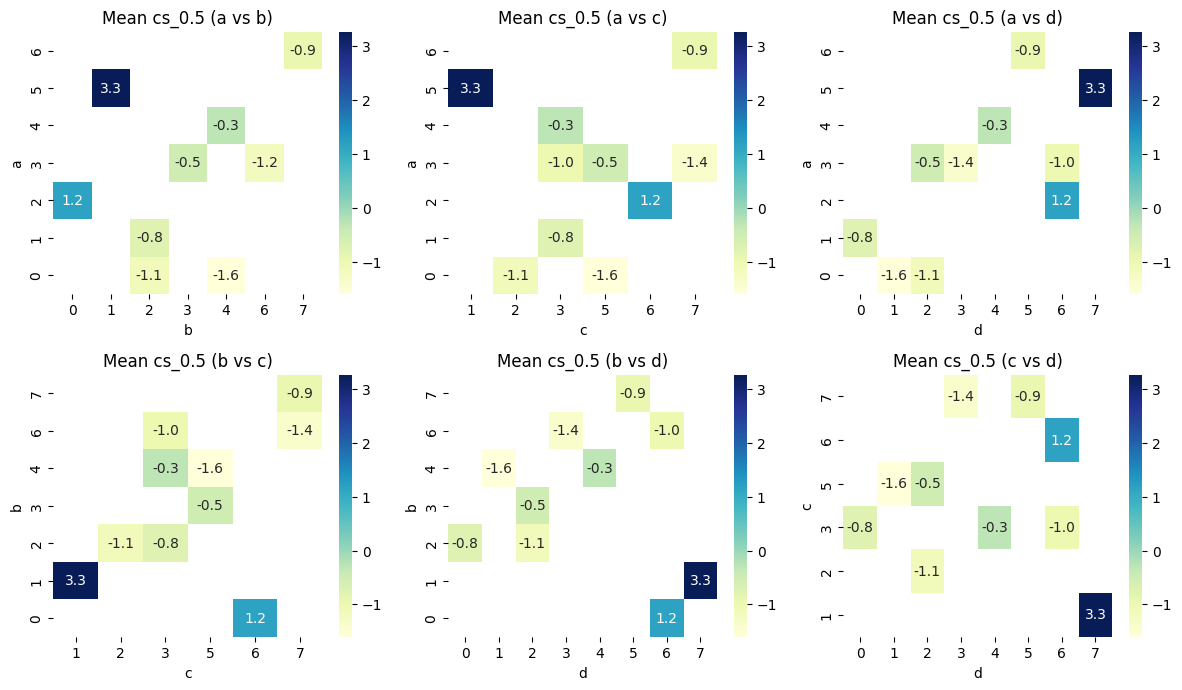

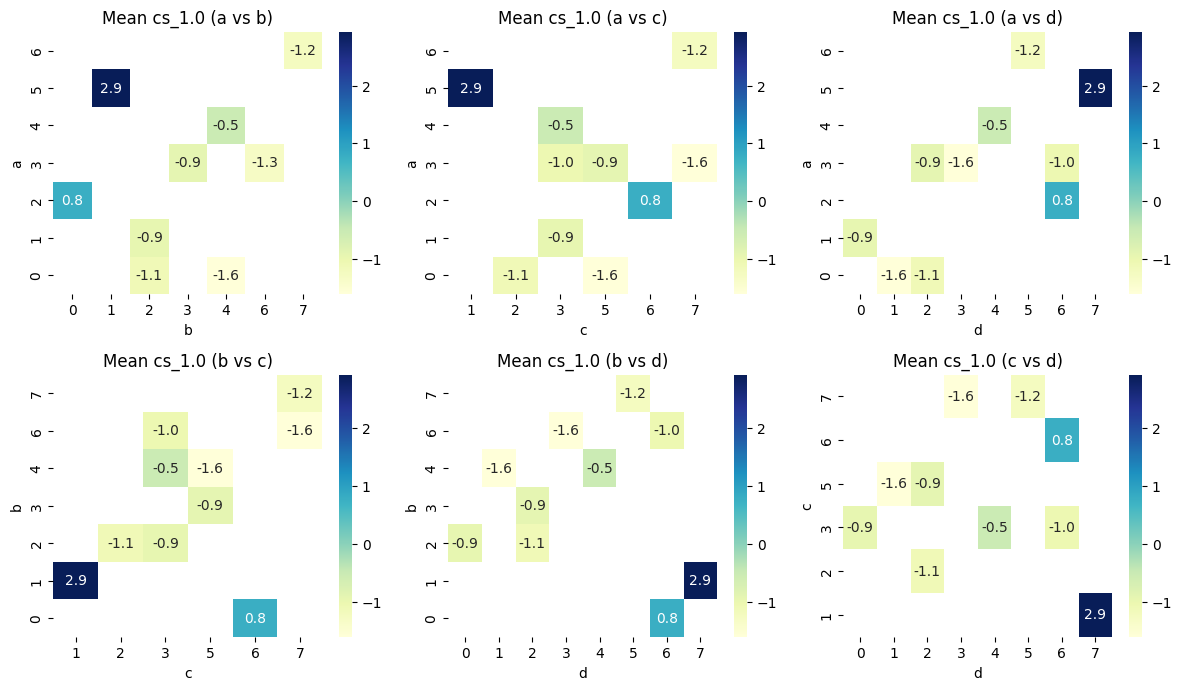

In [16]:
# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='cs_0.1', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean cs_0.1 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()

# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='cs_0.3', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean cs_0.3 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()

# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='cs_0.5', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean cs_0.5 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()

# ヒートマップを描画
plt.figure(figsize=(12, 10))
for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(3, 3, i)
    pivot_table = df.pivot_table(index=x, columns=y, values='cs_1.0', aggfunc='mean')
    sns.heatmap(pivot_table.sort_index(ascending=False), annot=True, fmt=".1f", cmap="YlGnBu", cbar=True)
    plt.title(f'Mean cs_1.0 ({x} vs {y})')
    plt.xlabel(y)
    plt.ylabel(x)

plt.tight_layout()
plt.show()